In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
notify = './sound/beep.wav'

In [3]:
pd.options.display.max_seq_items = None
pd.options.display.max_rows = None

Import Datasets

In [4]:
df_train = pd.read_csv('../Data/csv_result-Descriptors_Training.csv', index_col='id')

df_valid = pd.read_csv('../Data/csv_result-Descriptors_Calibration.csv', index_col='id')

In [5]:
df_train.head(1)

,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,Gs(U)_IB_58_N1,...,Z3_NO_UCR_S,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class
id,,,,,,,,,,,,,,,,,,,,,
1,5.59,14.91,13.69,6.45,12.11,28.79,32.4,0.06,0.09,0.04,...,0.69,23.12,0.64,0.76,-0.79,0.68,0.54,0.02,0.59,P


In [6]:
df_train[df_train['Pb_NO_PCR_V'] == -9999.00]['class'].value_counts()

N    29
Name: class, dtype: int64

Creating Input and Target variables

In [7]:
predictors = df_train.drop(columns='class').columns

X_train = df_train[predictors]
Y_train = df_train['class']

X_calib = df_valid[predictors]
Y_calib = df_valid['class']

#### Using Isolation forests to predict outliers

In [8]:
from sklearn.ensemble import IsolationForest

def detectOutliers(df, full_df, col_name='outliers'):
    
    clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), 
                      max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

    pred = clf.fit_predict(df)

    dummy_df = pd.concat(
        [
            full_df.reset_index(drop=True),
            pd.Series(pred, name=col_name)
        ], 
        axis=1)
    
    return dummy_df

Create input and target variables for dataset without outliers

In [9]:
df_outliers = detectOutliers(X_train, df_train)

In [10]:
df_no_outliers = df_outliers[df_outliers['outliers'] == 1]
X_train_wo = df_no_outliers[predictors]
Y_train_wo = df_no_outliers['class']

outliers  class
 1        N        16661
-1        N         2200
 1        P          928
-1        P          199
dtype: int64

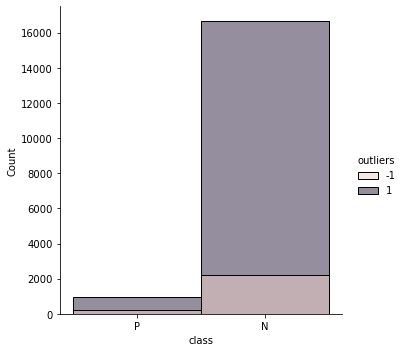

In [11]:
sns.displot(x='class',hue='outliers',data=df_outliers)
df_outliers[['outliers','class']].value_counts()

---
---
---

---
---
---
#### Using Gradient Boosting Classifier With Outliers

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [13]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
pred = model.predict(X_calib)

F1-score: [0.97095179 0.00704225]
Precision: [0.94392149 0.33333333]
Recall: [0.99957582 0.00355872]


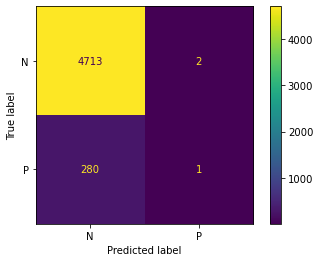

In [14]:
y_val = Y_calib.values
cm = confusion_matrix(Y_calib, pred)

print(f'F1-score: {f1_score(y_val, pred, average=None)}')
print(f'Precision: {precision_score(y_val, pred,average=None)}')
print(f'Recall: {recall_score(y_val, pred,average=None)}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

In [15]:
Y_calib.value_counts()

N    4715
P     281
Name: class, dtype: int64

#### Using Gradient Boosting Classifier without Outliers

In [16]:
model_wo = GradientBoostingClassifier()
model_wo.fit(X_train_wo, Y_train_wo)
pred_wo = model_wo.predict(X_calib)

F1-score: [0.96739468 0.04833837]
Precision: [0.94480388 0.16      ]
Recall: [0.99109226 0.02846975]


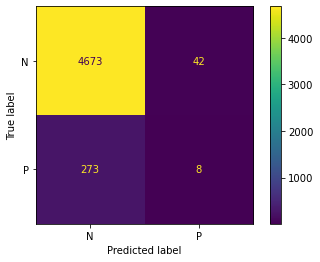

In [17]:
cm = confusion_matrix(y_val, pred_wo)

print(f'F1-score: {f1_score(y_val, pred_wo, average=None)}')
print(f'Precision: {precision_score(y_val, pred_wo,average=None)}')
print(f'Recall: {recall_score(y_val, pred_wo,average=None)}')


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

---
---
---
#### Create a pipeline for - Normalizing Data, Prediction Model

#### Create a pipeline for without outliers - Normalizing Data, Prediction Model

Without Outliers we are losing **TP**

---
---
---
#### Using SMOTE for oversampling and random undersampling mix

In [18]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

In [19]:
std = StandardScaler()
smote_model = GradientBoostingClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('std',std), ('over', over), ('under', under), ('model', smote_model)]
pipeline = Pipeline(steps=steps)


pipeline.fit(X_train, Y_train)
smote_pred = pipeline.predict(X_calib)

F1-score: [0.94502924 0.11925043]
Precision: [0.94754797 0.11437908]
Recall: [0.94252386 0.12455516]


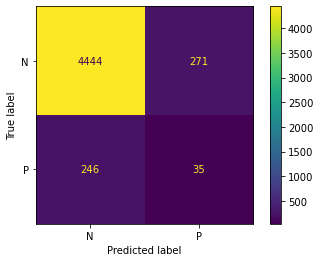

In [20]:
cm = confusion_matrix(y_val, smote_pred)

print(f'F1-score: {f1_score(y_val, smote_pred, average=None)}')
print(f'Precision: {precision_score(y_val, smote_pred,average=None)}')
print(f'Recall: {recall_score(y_val, smote_pred,average=None)}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

*Same as above without outliers*

In [21]:
std_wo = StandardScaler()
smote_model_wo = GradientBoostingClassifier()
over_wo = SMOTE(sampling_strategy=0.1)
under_wo = RandomUnderSampler(sampling_strategy=0.5)
steps_wo = [('std',std_wo), ('over', over_wo), ('under', under_wo), ('model', smote_model_wo)]
pipeline = Pipeline(steps=steps_wo)

pipeline.fit(X_train_wo, Y_train_wo)
smote_pred_wo = pipeline.predict(X_calib)

F1-score: [0.94473964 0.10652921]
Precision: [0.94675186 0.10299003]
Recall: [0.94273595 0.11032028]


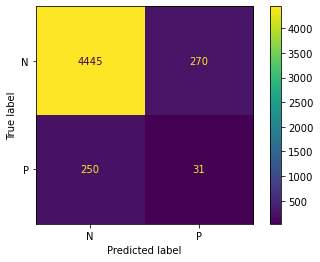

In [22]:
cm = confusion_matrix(y_val, smote_pred_wo)

print(f'F1-score: {f1_score(y_val, smote_pred_wo, average=None)}')
print(f'Precision: {precision_score(y_val, smote_pred_wo,average=None)}')
print(f'Recall: {recall_score(y_val, smote_pred_wo,average=None)}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

#### Parameter tunning XG BOOST

In [23]:
def modelfit(pip, x_train, y_train, x_test, y_test, predictors):
    
    
    #Fit the algorithm on the data
    pip.fit(x_train, y_train)
        
    #Predict training set:
    pred = pip.predict(x_test)
    
    y_val = y_test.values
    
    cm = confusion_matrix(y_val, pred)

    print(f'F1-score: {f1_score(y_val, pred, average=None)}')
    print(f'Precision: {precision_score(y_val, pred,average=None)}')
    print(f'Recall: {recall_score(y_val, pred,average=None)}')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N','P'])
    disp = disp.plot(include_values=True)

    plt.show()

In [24]:
def create_pipeline(scale, over, under, model):
    
    steps = [('std',scale), ('over', over), ('under', under), ('model', model)]
    return Pipeline(steps=steps)

Tuned Parameters

F1-score: [0.94231794 0.11745514]
Precision: [0.94746998 0.10843373]
Recall: [0.93722163 0.12811388]


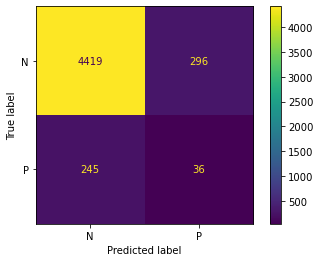

In [25]:
gbm_optimized = GradientBoostingClassifier(learning_rate=0.05, n_estimators=80, max_depth=11, max_features=17,
                                 min_samples_split=800, min_samples_leaf=50,subsample=0.75, random_state=10)

scale = StandardScaler()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

pipeline = create_pipeline(scale, over, under, gbm_optimized)

modelfit(pipeline, X_train, Y_train, X_calib, Y_calib,predictors)

Tuned Parameter 2

#### Finding the optimal parmeters using Grid Search 

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
scale = StandardScaler()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

*Find number of estimators*

In [ ]:
gbm = GradientBoostingClassifier(random_state=10) 

pipelineGSCV = create_pipeline(scale, over, under, gbm)

param_test1 = {'model__learning_rate':[0.05,0.01,0.005],
               'model__n_estimators':range(20,81,10),
               'model__max_depth':range(5,16,2), 
               'model__min_samples_split':range(200,1001,200),
               'model__min_samples_leaf':range(30,71,10),
               'model__max_features':range(7,20,2),
               'model__subsample':[0.6,0.7,0.75,0.8,0.85,0.9],}

gsearch1 = GridSearchCV(pipelineGSCV,param_test1,scoring=['precision','recall'],n_jobs=4, cv=5,refit=False)

gsearch1.fit(X_train,Y_train)

Audio(notify, autoplay=True)

In [ ]:
#gsearch1.gri

In [ ]:
pipelineGSCV.get_params().keys()

In [ ]:
GradientBoostingClassifier()